# Introduction: Writing Patent Abstracts with a Recurrent Neural Network

The purpose of this notebook is to develop a recurrent neural network using LSTM cells that can generate patent abstracts. We will look at using a _word level_ recurrent neural network and _embedding_ the vocab, both with pre-trained vectors and training our own embeddings. We will train the model by feeding in as the features a long sequence of words (for example 50 words) and then using the next word as the label. Over time, the network will (hopefully) learn to predict the next word in a given sequence and we can use the model predictions to generate entirely novel patent abstracts.

## Approach 

The approach to solving this problem is:

1. Read in training data: thousands of "neural network" patents
2. Convert patents to integer sequences: `tokenization`
3. Create training dataset using next word following a sequence as label
4. Build a recurrent neural network using word embeddings and LSTM cells
5. Load in pre-trained embeddings
6. Train network to predict next word from sequence
7. Generate new abstracts by feeding network a seed sequence
8. Repeat steps 2 - 7 using pre-trained embeddings
9. Try different model architecture to see if performance improves
10. For fun, create a simple game where we must guess if the output is human or computer! 

Each of these steps is relatively simple by itself, so don't be intimidated. We'll walk through the entire process and at the end will be able to have a working application of deep learning! 

In [1]:
# Set up IPython to show all outputs from a cell
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

## Read in Data 

Our data consists of patent abstracts by searching for the term "neural networks" on [patentsview query](http://www.patentsview.org/querydev) web interface. The data can be downloaded in a number of formats and can include a number of patent attributes (I only kept 4). 

In [2]:
import pandas as pd
import numpy as np

# Read in data
data = pd.read_csv('../data/neural_network_patent_query.csv', parse_dates = ['patent_date'])

# Extract abstracts
original_abstracts = list(data['patent_abstract'])
len(original_abstracts)

data.head()

3522

,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


### Brief Data Exploration

This data is extremely clean, which means we don't need to do any manual munging. We can still make a few simple plots out of curiousity though! 

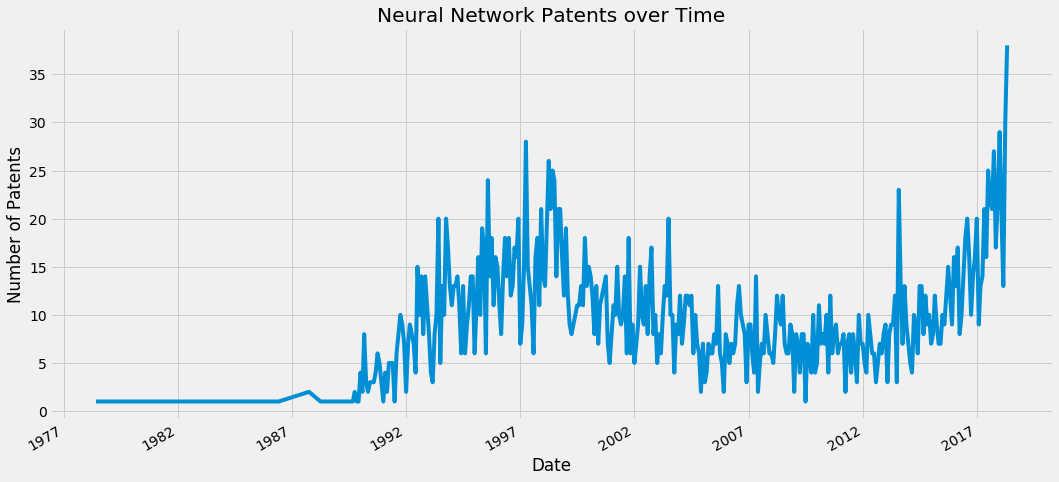

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

data['year-month'] = [pd.datetime(year, month, 1) for year, month in zip(data['patent_date'].dt.year,
                                                               data['patent_date'].dt.month)]

monthly = data.groupby('year-month')['patent_number'].count().reset_index()

monthly.set_index('year-month')['patent_number'].plot(figsize = (16, 8))
plt.ylabel('Number of Patents'); plt.xlabel('Date'); 
plt.title('Neural Network Patents over Time');

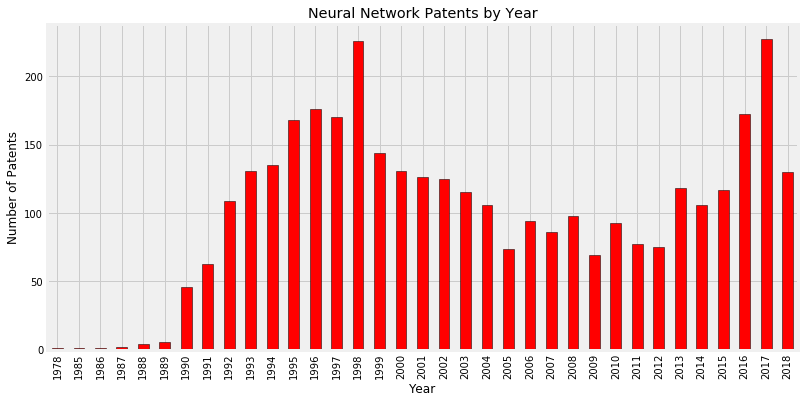

In [4]:
monthly.groupby(monthly['year-month'].dt.year)['patent_number'].sum().plot.bar(color = 'red', edgecolor = 'k',
                                                                               figsize = (12, 6))
plt.xlabel('Year'); plt.ylabel('Number of Patents'); plt.title('Neural Network Patents by Year');

The distribution of patents over time is interesting. I would expect 2018 to come out on top once the patents have been accepted. 

# Convert Text to Sequences

A neural network cannot process words, so we must convert the patent abstracts into integers. This is done using the Keras utility `Tokenizer`. By default, this will convert all words to lowercase and remove punctuation. Therefore, our model will not be able to write complete sentences. However, this limits the size of the vocabulary and means that more of the words (converted into tokens) will have pre-trained embeddings.

Later, we will not remove the capitalization and punctuation when we train our own embeddings.

This function takes a few parameters including a training length which is the number of words we will feed into the network as features with the next word the label. For example, if we set `training_length = 50`, then the model will take in 50 words as features and the 51st word as the label. 

For each abstract, we can make multiple training examples by slicing at different points. We can use the first 50 words as features with the 51st as a label, then the 2nd through 51st word as features and the 52nd as the label, then 3rd - 52nd with 53rd as label and so on. This gives us much more data to train on and the performance of the model is proportional to the amount of training data.

In [5]:
original_abstracts[1][:100]

'" This invention is a novel high-speed neural network based processor for solving the ""traveling sa'

In [3]:
from keras.preprocessing.text import Tokenizer

def make_sequences(texts, training_length = 50,
                   lower = True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""
    
    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)
    
    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts
    
    print(f'There are {num_words} unique words.')
    
    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [i for i, l in enumerate(seq_lengths) if l > training_length]
    
    new_texts = []
    new_sequences = []
    
    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])
        
    
    training_seq = []
    labels = []
    
    # Iterate through the sequences of tokens
    for seq in new_sequences:
        
        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length: i + 1]
            
            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(extract[-1])
    
    print(f'There are {len(training_seq)} training sequences.')
    
    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels

Using TensorFlow backend.


Let's see how this function works, the first time without removing capitalization or punctuation.

In [7]:
TRAINING_LENGTH = 50

filters = '!"%;[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, training_seq, labels = make_sequences(original_abstracts, 
                                                                                                       TRAINING_LENGTH,
                                                                                                       lower = False,
                                                                                                        filters = filters)

sequences[1][:10]

There are 21383 unique words.
There are 289132 training sequences.


[131, 74, 7, 2, 948, 2283, 6, 10, 43, 133]

In [8]:
' '.join(idx_word[i] for i in sequences[1][:100])

'This invention is a novel high-speed neural network based processor for solving the traveling salesman and other global optimization problems. It comprises a novel hybrid architecture employing a binary synaptic array whose embodiment incorporates the fixed rules of the problem, such as the number of cities to be visited. The array is prompted by analog voltages representing variables such as distances. The processor incorporates two interconnected feedback networks, each of which solves part of the problem independently and simultaneously, yet which exchange information dynamically.'

We can see that none of the punctuation was removed and as a result there are over 20000 words! Let's look at the most common words.

In [9]:
sorted(word_counts.items(), key = lambda x: x[1], reverse = True)[:15]

[('the', 30759),
 ('a', 21434),
 ('of', 20144),
 ('and', 12499),
 ('to', 11984),
 ('neural', 7231),
 ('is', 7190),
 ('for', 6771),
 ('in', 6123),
 ('network', 6099),
 ('The', 5813),
 ('an', 5286),
 ('are', 3595),
 ('by', 3536),
 ('data', 3362)]

Let's now contrast this with the approach we'll first use, removing the punctuation and converting all the words to lowercase.

In [10]:
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, training_seq, labels = make_sequences(original_abstracts, 
                                                                                                       TRAINING_LENGTH,
                                                                                                       lower = True,
                                                                                                       filters = filters)
' '.join(idx_word[i] for i in sequences[1][:100])
sorted(word_counts.items(), key = lambda x: x[1], reverse = True)[:15]

There are 11755 unique words.
There are 296866 training sequences.


'this invention is a novel high speed neural network based processor for solving the traveling salesman and other global optimization problems it comprises a novel hybrid architecture employing a binary synaptic array whose embodiment incorporates the fixed rules of the problem such as the number of cities to be visited the array is prompted by analog voltages representing variables such as distances the processor incorporates two interconnected feedback networks each of which solves part of the problem independently and simultaneously yet which exchange information dynamically'

[('the', 36614),
 ('a', 24904),
 ('of', 20240),
 ('and', 12968),
 ('to', 12150),
 ('network', 7829),
 ('neural', 7450),
 ('is', 7214),
 ('in', 7059),
 ('for', 6909),
 ('an', 6061),
 ('data', 4029),
 ('by', 3627),
 ('are', 3599),
 ('input', 3386)]

Our patents are no longer correct English, but we have reduced the size of the vocabulary by a factor of 2. This means our network will have fewer parameters but we won't be able to write complete sentences.

Each training sequence and labels are now represented as integers. We can convert this into a training and validation set by randomly splitting the features and labels. First, we need to convert the labels to one hot encoded vectors because our network will be trained using `categorical_crossentropy` and makes a prediction for each word in the vocabulary (we can train with the labels represented as simple integers, but I found performance was better and training faster when using a one-hot representation of the labels.

In [11]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X = np.array(training_seq)

# One hot encoding labels
y = to_categorical(labels)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_train.shape, y_train.shape

((207806, 50), (207806, 11755))

Each label is now a vector with a length equal to the number of words in the vocab.

In [12]:
def find_answer(index):
    """Find label corresponding to features for index in training data"""
    
    # Find features and label
    features = ' '.join(idx_word[i] for i in X_train[index])
    answer = idx_word[np.argmax(y_train[index])]
    
    print('Features:', features)
    print('\nLabel: ', answer)

In [13]:
find_answer(10)

Features: a non linear layer 2 the non linear layer 2 comprises a number of non linear activation function nodes 10 after passing through the non linear layer 2 the signal passes through the blocking layer 4 that is comprised of either binary signal blocking nodes or inverted symmetrical sigmoidal signal

Label:  blocking


In [14]:
find_answer(55)

Features: word and each word is assigned a score based on the least costly path that can be traversed through the output matrix the word or words with the overall lowest score or scores are returned a dtw is similarly used in training whereby the sample ink only need be labeled

Label:  at


# Pre-Trained Embeddings

Rather than training our own word embeddings, a very expensive operation, we can use word embeddings that were trained on a large corpus of words. The hope is that these embeddings will generalize from the training corpus to our needs.

This code downloads 100-dimensional word embeddings if you don't already have them. There are a number of different pre-trained word embeddings you can find from [Stanford online](https://nlp.stanford.edu/data/).

In [15]:
import os
from keras.utils import get_file

# Vectors to use
glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.zip'

# Download word embeddings if they are not present
if not os.path.exists(glove_vectors):
    glove_vectors = get_file('glove.6B.zip', 'http://nlp.stanford.edu/data/glove.6B.zip')
    os.system(f'unzip {glove_vectors}')
    
# Load in unzipped file 
glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

(400000, 101)

Now we separated into the words and the vectors.

In [16]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

del glove

vectors[100], words[100]

(array([-3.9551e-01,  5.4660e-01,  5.0315e-01, -6.3682e-01, -4.5470e-01,
         3.0889e-01, -4.9240e-02,  2.7191e-01,  3.1562e-01, -3.2879e-01,
         2.5089e-01,  1.4508e-01,  3.5136e-01, -2.2793e-01, -1.5894e-01,
        -5.1527e-01, -2.7978e-01,  3.6470e-01, -3.9425e-01,  3.3299e-01,
         4.3051e-01,  1.8300e-01,  2.5095e-01, -1.8547e-01,  3.4698e-01,
         5.5137e-02, -4.5979e-01, -8.2963e-01, -1.8523e-02, -3.6772e-01,
         4.5566e-02,  7.1052e-01, -2.2782e-02, -8.0889e-02,  2.0685e-01,
         4.9855e-01, -5.9794e-02, -8.0048e-03, -2.3823e-01, -3.3759e-01,
        -2.4201e-01, -2.3788e-01, -1.1362e-03, -4.0395e-01, -4.4859e-01,
        -3.2189e-01,  4.8405e-01, -2.7999e-02,  1.0148e-01, -9.3585e-01,
        -8.7522e-02, -3.9959e-01,  3.6545e-01,  1.3726e+00, -3.0713e-01,
        -2.5940e+00,  2.2431e-01, -4.1168e-02,  1.7765e+00,  4.0010e-01,
        -1.0996e-01,  1.4178e+00, -2.6154e-01,  1.8617e-01,  7.9328e-01,
        -1.1709e-01,  8.7541e-01,  4.3911e-01,  3.4

Next we want to keep only those words that appear in our vocabulary. For words that are in our vocabulary but don't have an embedding, they will be represented as all 0s (a shortcoming that we can address by training our own embeddings.)

In [17]:
vectors.shape

(400000, 100)

In [19]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)
    
    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1
        
print(f'There were {not_found} words without pre-trained embeddings.')

There were 1224 words without pre-trained embeddings.


Each word is represented by 100 numbers with a number of words that can't be found. We can find the closest words to a given word in embedding space using the cosine distance. This requires first normalizing the vectors to have a magnitude of 1.

In [20]:
# Normalize and convert nan to 0
embedding_matrix = embedding_matrix / np.linalg.norm(embedding_matrix, axis = 1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [21]:
def find_closest(query, embedding_matrix, n = 10):
    """Find closest words to a query word in embeddings"""
    
    idx = word_idx.get(query, None)
    # Handle case where query is not in vocab
    if idx is None:
        print(f'{query} not found in vocab.')
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec == 0):
            print(f'{query} has no pre-trained embedding.')
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)
            
            # Sort indexes in reverse order
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]
            
    print(f'Query: {query}\n')
    max_len = max([len(i) for i in closest])
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:15} Cosine Similarity: {round(dist, 4)}')

In [22]:
find_closest('the', embedding_matrix)

Query: the

Word: the             Cosine Similarity: 1.0
Word: this            Cosine Similarity: 0.8573
Word: part            Cosine Similarity: 0.8508
Word: one             Cosine Similarity: 0.8503
Word: of              Cosine Similarity: 0.8329
Word: same            Cosine Similarity: 0.8325
Word: first           Cosine Similarity: 0.821
Word: on              Cosine Similarity: 0.82
Word: its             Cosine Similarity: 0.8169
Word: as              Cosine Similarity: 0.8128


In [23]:
find_closest('neural', embedding_matrix, 10)

Query: neural

Word: neural          Cosine Similarity: 1.0
Word: neuronal        Cosine Similarity: 0.6841
Word: cortical        Cosine Similarity: 0.676
Word: plasticity      Cosine Similarity: 0.6625
Word: pathways        Cosine Similarity: 0.6534
Word: neurons         Cosine Similarity: 0.6485
Word: sensory         Cosine Similarity: 0.6391
Word: cognitive       Cosine Similarity: 0.6125
Word: brain           Cosine Similarity: 0.6082
Word: physiological   Cosine Similarity: 0.6022


In [24]:
find_closest('wonder', embedding_matrix)

wonder not found in vocab.


In [25]:
find_closest('dnn', embedding_matrix, 10)

dnn has no pre-trained embedding.


# Build Model

With data encoded as integers and an embedding matrix of pre-trained word vectors, we're ready to build the recurrent neural network. This model is relatively simple and uses an LSTM cell as the heart of the network. After converting the words into embeddings, we pass them through a single LSTM layer, then into a fully connected layer with `relu` activation before the final output layer with a `softmax` activation. The final layer produces a probability for every word in the vocab. 

When training, these predictions are compared to the actual label using the `categorical_crossentropy` to calculate a loss. The parameters (weights) in the network are then updated using the Adam optimizer (a variant on Stochastic Gradient Descent) with gradients calculated through backpropagation. Fortunately, Keras handles all of this behind the scenes, so we just have to set up the network and then start the training. The most difficult part is figuring out the correct shapes for the inputs and outputs into the model.

In [9]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking
from keras.optimizers import Adam

from keras.utils import plot_model

In [49]:
def word_level_model(embedding_matrix = None):
    """Build a word-level recurrent neural network to predict the 
       next word in a sequence of text"""
    
    model = Sequential()
    # Map words to an embedding
    model.add(Embedding(input_dim=num_words, output_dim=embedding_matrix.shape[1],
                        weights = [embedding_matrix], trainable = False,
                        input_length = TRAINING_LENGTH, mask_zero = True))
    # Mask the zeros from the embeddings
    model.add(Masking())
    # Long Short Term Memory Cell layer
    model.add(LSTM(128, return_sequences=False, dropout=0.1))
    
    # Dense fully connected layer
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    
    # Predicted outputs
    model.add(Dense(num_words, activation = 'softmax'))
    
    return model

model = word_level_model(embedding_matrix)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1175500   
_________________________________________________________________
masking_4 (Masking)          (None, 50, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 11755)             1516395   
Total params: 2,825,655
Trainable params: 1,650,155
Non-trainable params: 1,175,500
__________________________________________________________

Using pre-trained embeddings means we have about half the parameters to train. However, this also means that the embeddings might not be the best for our data, and there are a number of words with no embeddings.

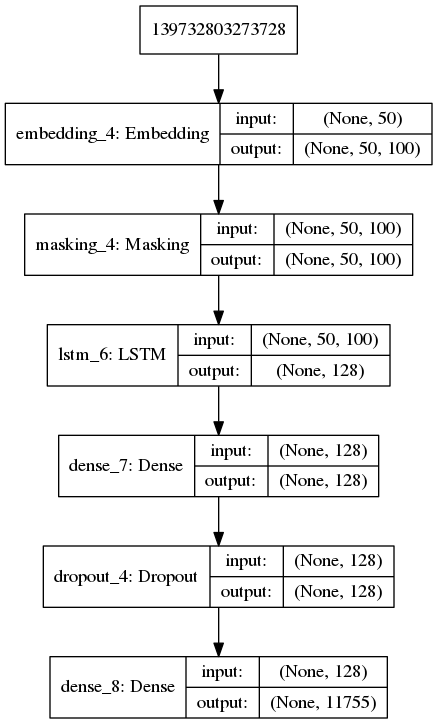

In [50]:
model_name = 'pre-trained-rnn'
model_dir = '../models/'

plot_model(model, to_file = f'{model_dir}{model_name}.png', show_shapes = True)
from IPython.display import Image

Image(f'{model_dir}{model_name}.png')

# Train Model

We can now train the model on our training examples. We'll make sure to use early stopping with a validation set to stop the training when the loss on the validation set is no longer decreasing. Also, we'll save the best model every time the validation loss decreases so we can then load in the best model to generate predictions.

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 2048
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint(f'{model_dir}{model_name}.h5', save_best_only = True, save_weights_only = False)]

In [14]:
X_train.shape
y_train.shape

(202392, 50)

(202392, 21383)

The model needs a loss to minimize (`categorical_crossentropy`) as well as a method for updating the weights using the gradients (`Adam`). We will also monitor accuracy which is not a good loss but can give us a more interpretable measure of the model performance.

__Depending on your machine, this may take several hours to run.__

In [53]:
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = 150, callbacks=callbacks, 
                    validation_data = (X_valid, y_valid))

Train on 207806 samples, validate on 89060 samples
Epoch 1/150
207806/207806 [==============================] - 42s 201us/step - loss: 6.9259 - acc: 0.0795 - val_loss: 6.3615 - val_acc: 0.0916
Epoch 2/150
207806/207806 [==============================] - 40s 191us/step - loss: 6.3735 - acc: 0.0921 - val_loss: 6.3469 - val_acc: 0.0916
Epoch 3/150
207806/207806 [==============================] - 40s 191us/step - loss: 6.3415 - acc: 0.0921 - val_loss: 6.3289 - val_acc: 0.0916
Epoch 4/150
207806/207806 [==============================] - 40s 191us/step - loss: 6.3044 - acc: 0.0925 - val_loss: 6.2758 - val_acc: 0.0916
Epoch 5/150
207806/207806 [==============================] - 40s 191us/step - loss: 6.2301 - acc: 0.1030 - val_loss: 6.1850 - val_acc: 0.1099
Epoch 6/150
207806/207806 [==============================] - 40s 191us/step - loss: 6.1567 - acc: 0.1110 - val_loss: 6.1164 - val_acc: 0.1164
Epoch 7/150
207806/207806 [==============================] - 40s 191us/step - loss: 6.0855 - acc:

Epoch 58/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.8349 - acc: 0.1787 - val_loss: 5.0931 - val_acc: 0.1889
Epoch 59/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.8205 - acc: 0.1793 - val_loss: 5.0947 - val_acc: 0.1890
Epoch 60/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.8079 - acc: 0.1801 - val_loss: 5.0886 - val_acc: 0.1889
Epoch 61/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.7957 - acc: 0.1802 - val_loss: 5.0783 - val_acc: 0.1904
Epoch 62/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.7802 - acc: 0.1820 - val_loss: 5.0728 - val_acc: 0.1904
Epoch 63/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.7702 - acc: 0.1813 - val_loss: 5.0695 - val_acc: 0.1900
Epoch 64/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.7599 - acc: 0.1819 - val_loss: 5.0627 - val_acc: 0.1917

207806/207806 [==============================] - 40s 192us/step - loss: 4.3433 - acc: 0.2110 - val_loss: 4.9375 - val_acc: 0.2151
Epoch 119/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.3388 - acc: 0.2118 - val_loss: 4.9214 - val_acc: 0.2151
Epoch 120/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.3356 - acc: 0.2118 - val_loss: 4.9258 - val_acc: 0.2154
Epoch 121/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.3337 - acc: 0.2119 - val_loss: 4.9299 - val_acc: 0.2152
Epoch 122/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.3255 - acc: 0.2124 - val_loss: 4.9263 - val_acc: 0.2167
Epoch 123/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.3228 - acc: 0.2135 - val_loss: 4.9249 - val_acc: 0.2162
Epoch 124/150
207806/207806 [==============================] - 40s 192us/step - loss: 4.3189 - acc: 0.2127 - val_loss: 4.9283 - val_acc: 0.2165


By the end of training, our model achieves a respectable __ accuracy on the validation data. To put this in perspective, let's see what the accuracy would be if we simply guessed randomly based on the word frequencies.

In [54]:
total_words = sum(word_counts.values())
naive_guess = [word_counts[word]/total_words for word in word_idx.keys()]

In [56]:
naive_guess[:10]

[0.07758962307133185,
 0.052774675615022894,
 0.04289107912175006,
 0.02748080603018057,
 0.025747362219825258,
 0.016590625417202628,
 0.015787477245901082,
 0.015287363872742338,
 0.014958899581049094,
 0.014641030911668535]

# Training Own Embeddings

In [4]:
TRAINING_LENGTH = 50

filters = '!"%;[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, training_seq, labels = make_sequences(original_abstracts, 
                                                                                                       TRAINING_LENGTH,
                                                                                                       lower = False,
                                                                                                        filters = filters)

sequences[1][:10]

There are 21383 unique words.
There are 289132 training sequences.


[131, 74, 7, 2, 948, 2283, 6, 10, 43, 133]

In [6]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X = np.array(training_seq)

# One hot encoding labels
y = to_categorical(labels)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_train.shape, y_train.shape

((202392, 50), (202392, 21383))

In [11]:
def word_level_model(embedding_dim = 100):
    """Build a word-level recurrent neural network to predict the 
       next word in a sequence of text"""
    
    model = Sequential()
    # Map words to an embedding
    model.add(Embedding(input_dim=num_words, output_dim=embedding_dim,
                        trainable = True,
                        input_length = TRAINING_LENGTH, mask_zero = False))
    
    # Long Short Term Memory Cell layer
    model.add(LSTM(128, return_sequences=False, dropout=0.1))
    
    # Dense fully connected layer
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    
    # Predicted outputs
    model.add(Dense(num_words, activation = 'softmax'))
    
    return model

model = word_level_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2138300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 21383)             2758407   
Total params: 5,030,467
Trainable params: 5,030,467
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_name = 'training-rnn'
model_dir = '../models/'

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint(f'{model_dir}{model_name}.h5', save_best_only = True, save_weights_only = False)]

In [ ]:
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = 150, callbacks=callbacks, 
                    validation_data = (X_valid, y_valid))

Train on 202392 samples, validate on 86740 samples
Epoch 1/150
 14336/202392 [=>............................] - ETA: 1:03 - loss: 9.9655 - acc: 0.0406

In [ ]:
sequences = tokenizer.texts_to_sequences(abstracts)
sequences[10][:15]

In [ ]:
len_idx = {idx:len(x) for idx, x in enumerate(sequences)}
over_idx = [x[0]for x in len_idx.items() if x[1] > 50]
len(over_idx), over_idx[:10]

In [ ]:
new_abstracts = []
new_sequences = []
for i in over_idx:
    new_abstracts.append(original_abstracts[i])
    new_sequences.append(sequences[i])
    
len(new_abstracts), len(new_sequences)

In [ ]:
sequences = new_sequences[:]
abstracts = new_abstracts[:]

In [ ]:
training_length = 50
seq = []
abst = []
labels = []
abstract_dict = {}
n_seq = 0

for idx, abstract in enumerate(sequences):
    for i in range(training_length, len(abstract)):
        abstract_dict[n_seq] = idx
        s = abstract[i - training_length:i + 1]
        seq.append(s[:-1])
        labels.append(s[-1])
        n_seq += 1

In [ ]:
n_seq

In [ ]:
seq_0 = []
seq_1 = []
for i, j in zip(seq[0], seq[1]):
    seq_0.append(idx_word[i])
    seq_1.append(idx_word[j])

' '.join(seq_0)
' '.join(seq_1)

In [ ]:
idx_word[labels[0]]
idx_word[labels[1]]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, TimeDistributed, Masking, Dropout

In [ ]:
num_words = len(word_idx) + 1

In [ ]:
import os
from keras.utils import get_file


glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.zip'

if not os.path.exists(glove_vectors):
    glove_vectors = get_file('glove.6B.zip', 'http://nlp.stanford.edu/data/glove.6B.zip')
    os.system(f'unzip {glove_vectors}')
    
glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

In [ ]:
words = glove[:, 0]
vectors = glove[:, 1:].astype('float')
vectors.shape

In [ ]:
word_vectors = {word: vector for word, vector in zip(words, vectors)}

word_index = tokenizer.word_index
num_words = len(word_index) + 1

# Create empty matrix to hold embeddings
embedding_matrix = np.zeros((num_words, vectors.shape[1]))
embedding_matrix.shape

In [ ]:
not_in_count = 0
for idx, word in tokenizer.index_word.items():
    vector = word_vectors.get(word)
    if vector is not None:
        embedding_matrix[idx, :] = vector
    else:
        not_in_count += 1
        
print(f'There are {not_in_count} words not in the pre-trained embeddings.')

In [ ]:
def make_word_level_model():

    model = Sequential()

    model.add(Embedding(input_dim = num_words, 
                        output_dim = embedding_matrix.shape[1], input_length = training_length,
                        weights = [embedding_matrix], mask_zero = True, 
                        trainable = False))

    model.add(Masking(mask_value = 0.0))
    model.add(LSTM(128, return_sequences=False, dropout=0.1))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_words, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

model = make_word_level_model()
model.summary()

In [ ]:
from keras.utils import to_categorical

y = to_categorical(labels)
y.shape

In [ ]:
X = np.array(seq)
X.shape

In [ ]:
f_train = 0.75
idx_train = int(f_train * len(X))

X_train = X[:idx_train]
X_valid = X[idx_train:]

y_train = y[:idx_train]
y_valid = y[idx_train:]

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint('../models/better.h5', monitor = 'val_loss', 
                             save_best_only = True, save_weights_only = False)]

In [ ]:
history = model.fit(X_train, y_train, epochs = 30, callbacks=callbacks, batch_size = 1024, 
                    validation_data = (X_valid, y_valid))

In [ ]:
import random
def generate_output(new_words = 50, diversity = 1):
    seed = random.randint(0, len(seq))
    print(seed)
    seed = seq[seed]
    generated = seed[:] + ['#']
    
    for i in range(new_words):
    
        preds = model.predict(np.array(seed).reshape(1, -1))[0]
        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)
        # Softmax
        preds = exp_preds / sum(exp_preds)
        
        probas = np.random.multinomial(1, preds, 1)[0]
        
        next_idx = np.argmax(probas)
        seed = seed[1:] + [next_idx]
        generated.append(next_idx)
    return generated, preds

In [ ]:
new_abstract, preds = generate_output(diversity = 2)

n = []
for i in new_abstract:
    n.append(idx_word.get(i, '#'))
    
' '.join(n)

In [ ]:
new_abstract, preds = generate_output(diversity = 2)

n = []
for i in new_abstract:
    n.append(idx_word.get(i, '#'))
    
' '.join(n)

In [ ]:
exp_preds= np.exp(preds)
preds = exp_preds / sum(exp_preds)
preds

In [ ]:
preds.sum()

In [ ]:
preds.shape

In [ ]:
np.argmax(np.random.multinomial(1, preds, 1)[0])

In [ ]:
def make_word_level_model():

    model = Sequential()

    model.add(Embedding(input_dim = num_words, 
                        output_dim = embedding_matrix.shape[1], input_length = training_length,
                        weights = None, mask_zero = True, 
                        trainable = True))

    model.add(Masking(mask_value = 0.0))
    model.add(LSTM(128, return_sequences=True, dropout=0.1))
    model.add(LSTM(128, return_sequences=False, dropout=0.1))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_words, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

model = make_word_level_model()
model.summary()

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint('../models/better_trained_embeddings.h5', monitor = 'val_loss', 
                             save_best_only = True, save_weights_only = False)]

In [ ]:
history = model.fit(X_train, y_train, epochs = 150, callbacks=callbacks, batch_size = 1024, 
                    validation_data = (X_valid, y_valid))

In [ ]:
from keras.models import load_model

model = load_model('../models/better_trained_embeddings.h5')

In [ ]:
import random

def generate_output(new_words = 50, diversity = 1):
    s = random.choice(sequences)
    seed_idx = random.randint(0, len(s) - training_length)
    end_idx = seed_idx + training_length
    
    seed = s[seed_idx:end_idx] 
    generated = seed[:] + ['#']
    
    actual = generated[:] + s[end_idx:end_idx + training_length]

    for i in range(new_words):
    
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)
       
        # Softmax
        preds = exp_preds / sum(exp_preds)
        
        probas = np.random.multinomial(1, preds, 1)[0]
        
        next_idx = np.argmax(probas)
        seed = seed[1:] + [next_idx]
        generated.append(next_idx)
    
    return generated, actual

In [ ]:
new_abstract, actual = generate_output(diversity = 1.5)

n = []
a = []

for i in new_abstract:
    n.append(idx_word.get(i, '#'))
    
for i in actual:
    a.append(idx_word.get(i, '#'))

' '.join(n[:len(a)])
' '.join(a)

# Keep Punctuation

The default Tokenizer removes punctuation. Which means we get slightly non-sense sentences. We can keep in the punctuation and then train our own embeddings.

In [ ]:
tokenizer = Tokenizer(lower = False, filters = '!"#%(),-.:;=?[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(abstracts)

word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

len(word_idx)

In [ ]:
list(sorted(tokenizer.word_counts.items(), key = lambda x: x[1], reverse = True))[:15]

In [ ]:
training_length = 50
word_idx, idx_word, num_words, abstracts, sequences, training_seq, labels = make_sequences(original_abstracts, training_length)

In [ ]:
word_idx, idx_word, num_words, abstracts, sequences, training_seq, labels = make_sequences(original_abstracts, training_length, 
                                                                                           lower = False)

In [ ]:
word_idx, idx_word, num_words, abstracts, sequences, training_seq, labels = make_sequences(original_abstracts, training_length,
                                                                                lower = False,
                                                                                filters = '!"%;[\\]^_`{|}~\t\n')

In [ ]:
def make_word_level_model(embedding_dim = 100):

    model = Sequential()
    model.add(Embedding(input_dim = num_words, 
                        output_dim = embedding_dim, 
                        input_length = training_length,
                        weights = None, mask_zero = False, 
                        trainable = True))
    
    model.add(LSTM(128, return_sequences=False, dropout=0.1))
#     model.add(LSTM(128, return_sequences=False, dropout=0.1))
    
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(num_words, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

model = make_word_level_model()
model.summary()

In [ ]:
from keras.utils import to_categorical

X = np.array(training_seq)
X.shape

y = to_categorical(labels)
y.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, shuffle = True)

X_train.shape
y_train.shape

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint('../models/better_trained_embeddings_all_vocab_1_lstm_layer.h5', monitor = 'val_loss', 
                             save_best_only = True, save_weights_only = False)]

In [ ]:
history = model.fit(X_train, y_train, epochs = 150, callbacks=callbacks,
                    batch_size = 256, validation_data = (X_valid, y_valid))

In [ ]:
import random

def generate_output(new_words = 50, diversity = 1.5):
    s = random.choice(sequences)
    seed_idx = random.randint(0, len(s) - training_length)
    end_idx = seed_idx + training_length
    
    seed = s[seed_idx:end_idx] 
    generated = seed[:] + ['#']
    
    actual = generated[:] + s[end_idx:end_idx + training_length]

    for i in range(new_words):
    
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)
       
        # Softmax
        preds = exp_preds / sum(exp_preds)
        
        probas = np.random.multinomial(1, preds, 1)[0]
        
        next_idx = np.argmax(probas)
        seed = seed[1:] + [next_idx]
        generated.append(next_idx)
    
    return generated, actual

In [ ]:
def generate_and_display_output():
    gen, actual = generate_output()

    n = []
    a = []

    for i in gen:
        n.append(idx_word.get(i, '< --- >'))

    for i in actual:
        a.append(idx_word.get(i, '< --- >'))

    print(' '.join(n[:len(a)]))
    print('\n\n')
    print(' '.join(a))

In [ ]:
generate_and_display_output()

In [ ]:
generate_and_display_output()

In [ ]:
def guess_human():
    gen, actual = generate_output()
    
    n = []
    a = []

    for i in gen:
        n.append(idx_word.get(i, '< --- >'))

    for i in actual:
        a.append(idx_word.get(i, '< --- >'))
        
        
    output = {'c': ' '.join(n[:len(a)]), 'h': ' '.join(a)}
    h_or_c = random.choice(list(output.keys()))
    
    not_h_or_c = [x for x in output.keys() if x != h_or_c][0]
    print(output[h_or_c])
    print('\n')
    print(output[not_h_or_c])
    print('\n')
    
    guess = input('Enter "h" for human first or "c" for computer first: ')
    print('\n')
    
    if guess == 'h' and h_or_c == 'h':
        print('Correct')
    elif guess == 'c' and h_or_c == 'c':
        print('Correct')
    else:
        print('Incorrect')

In [ ]:
guess_human()

In [ ]:
guess_human()